In [44]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
import requests_cache
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter

In [45]:
# Define a custom session class with caching and rate limiting
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

# Configure the cache and rate limiter
session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND * 5)),  # Max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache"),
)

# Set a custom User-Agent header (optional but recommended)
session.headers.update({'User-Agent': 'my-program/1.0'})

# Define a function to fetch and display options data
def fetch_options_data(ticker):
    # Get the ticker object with the custom session
    stock = yf.Ticker(ticker, session=session)

    # Get current stock price
    S0 = stock.history(period='1d')['Close'].iloc[0]
    
    # Get options expiration dates
    exp_dates = stock.options

    print(exp_dates)
    
    # Find the expiration date approximately three months from now
    today = datetime.today()
    three_months_later = today + timedelta(days=90)
    
    # Select the expiration date closest to three months from now
    selected_exp_date = min(exp_dates, key=lambda date: abs(datetime.strptime(date, '%Y-%m-%d') - three_months_later))
    
    # Fetch the option chain for the selected expiration date
    option_chain = stock.option_chain(selected_exp_date)
    
    # Extract call options data
    calls = option_chain.calls
    
    # Extract relevant data
    strike_prices = calls['strike']
    implied_vols = calls['impliedVolatility']
    last_trade_date = calls['lastTradeDate']
    last_price = calls['lastPrice']
    bid = calls['bid']
    ask = calls['ask']
    change = calls['change']
    percent_change = calls['percentChange']
    volume = calls['volume']
    open_interest = calls['openInterest']

    # Create a DataFrame to display the data
    options_data = pd.DataFrame({
        'Last Trade Date': last_trade_date,
        'Strike Price': strike_prices,
        'Last Price': last_price,
        'Bid': bid,
        'Ask': ask,
        'Change': change,
        '% Change': percent_change,
        'Volume': volume,
        'Open Interest': open_interest,
        'Implied Volatility': implied_vols
    })
    
    options_data = options_data[options_data['Implied Volatility'] > 0.1]

    # Display the results in a table
    print(f"Selected Expiration Date: {selected_exp_date}")
    display(options_data.head())

    return S0, options_data['Strike Price'].values, options_data['Implied Volatility'].values, selected_exp_date

S0, strike_prices, implied_vols, exp_date = fetch_options_data('INTC')

('2024-07-26', '2024-08-02', '2024-08-09', '2024-08-16', '2024-08-23', '2024-08-30', '2024-09-20', '2024-10-18', '2024-11-15', '2024-12-20', '2025-01-17', '2025-03-21', '2025-06-20', '2025-09-19', '2025-12-19', '2026-01-16', '2026-06-18', '2026-12-18')
Selected Expiration Date: 2024-10-18


,Last Trade Date,Strike Price,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,2024-07-22 14:51:57+00:00,20.0,13.50,12.15,14.05,0.0,0.0,2,90,0.612309
1,2024-07-19 15:45:15+00:00,21.0,12.25,11.25,13.25,0.0,0.0,5,25,0.654300
2,2024-07-16 18:10:10+00:00,22.0,12.30,9.25,12.30,0.0,0.0,6,27,0.963868
3,2024-07-15 18:42:17+00:00,23.0,11.80,9.20,11.35,0.0,0.0,5,31,0.557622
4,2024-07-09 16:24:58+00:00,24.0,10.50,8.35,10.30,0.0,0.0,3,14,0.525395


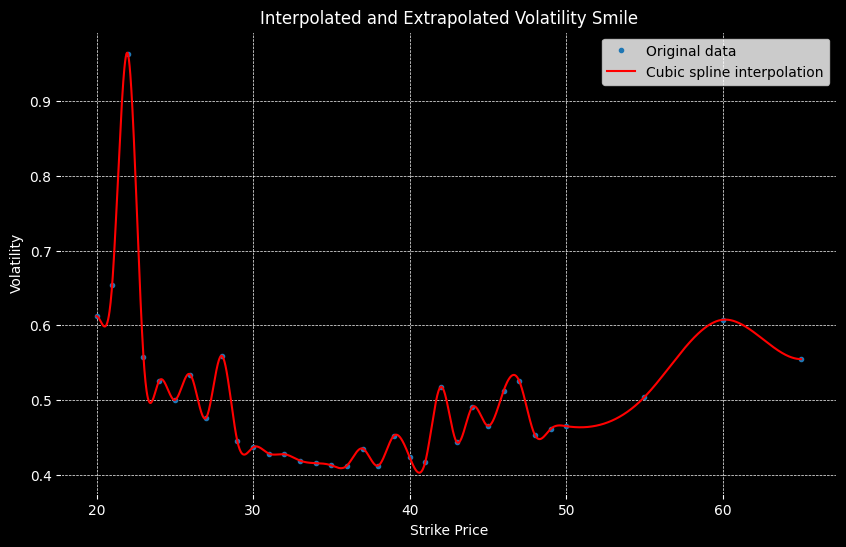

In [46]:
# Define the function for cubic spline interpolation
def interpolate(strikes, ivols):
    spline_fit = CubicSpline(strikes, ivols, bc_type='clamped')
    # Generate new strike prices for interpolation
    new_strikes = np.linspace(min(strikes), max(strikes), 2000)
    new_ivols = spline_fit(new_strikes)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, ivols, '.', label='Original data')
    plt.plot(new_strikes, new_ivols, label='Cubic spline interpolation', color ='red')
    plt.xlabel('Strike Price', color = 'white')
    plt.ylabel('Volatility', color = 'white')
    plt.title('Interpolated and Extrapolated Volatility Smile', color = 'white')
    plt.legend()
    # Set black background and white grid
    plt.gca().set_facecolor('black')
    plt.gcf().set_facecolor('black')
    plt.grid(color='white', linestyle='--', linewidth=0.5)
    plt.tick_params(colors='white')
    plt.show()

    return new_strikes, new_ivols

# Interpolate volatilities
new_strikes, new_ivols = interpolate(strike_prices, implied_vols)


In [47]:
def black_scholes_call(S0, X, T, r, sigma):
    d1 = (np.log(S0 / X) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S0 * norm.cdf(d1)) - (X * np.exp(-r * T) * norm.cdf(d2))
    return call_price

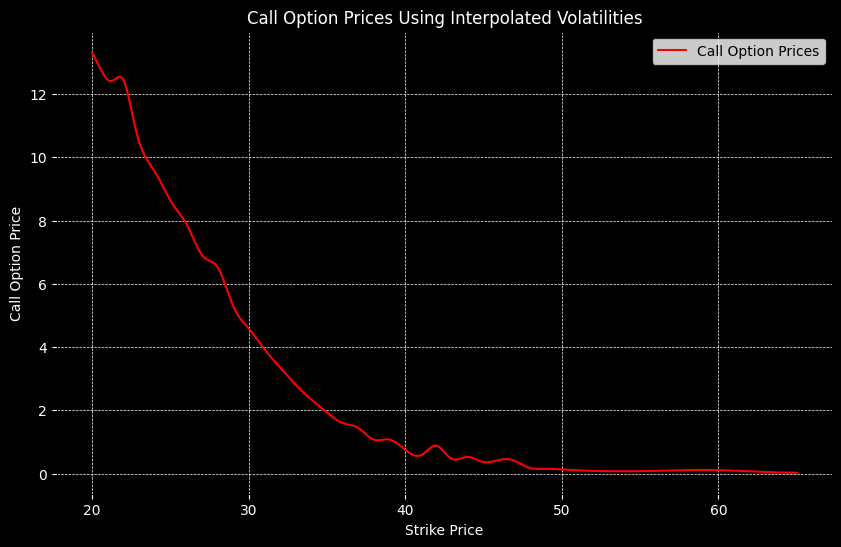

In [48]:
# Define the function to calculate and plot call option prices
def call_valuation(S0, T, r, new_strikes, new_ivols):
    call_prices = [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(new_strikes, new_ivols)]
    # Plot the call option prices
    plt.figure(figsize=(10, 6))
    plt.plot(new_strikes, call_prices, label='Call Option Prices', color = 'red')
    plt.xlabel('Strike Price', color = 'white')
    plt.ylabel('Call Option Price', color = 'white')
    plt.title('Call Option Prices Using Interpolated Volatilities', color = 'white')
    plt.legend()
    # Set black background and white grid
    plt.gca().set_facecolor('black')
    plt.gcf().set_facecolor('black')
    plt.grid(color='white', linestyle='--', linewidth=0.5)
    plt.tick_params(colors='white')
    plt.show()
    return call_prices

# Example parameters for Black-Scholes calculation
T = (datetime.strptime(exp_date, '%Y-%m-%d') - datetime.today()).days / 365.25  # Time to maturity in years
r = 0.05  # Risk-free interest rate (5%)

# Calculate call option prices
call_prices = call_valuation(S0, T, r, new_strikes, new_ivols)

Fitted parameters for log-normal distribution:
Shape (s): 0.1538760682370551
Location (loc): -5.375347501750185
Scale (scale): 38.41488847291744


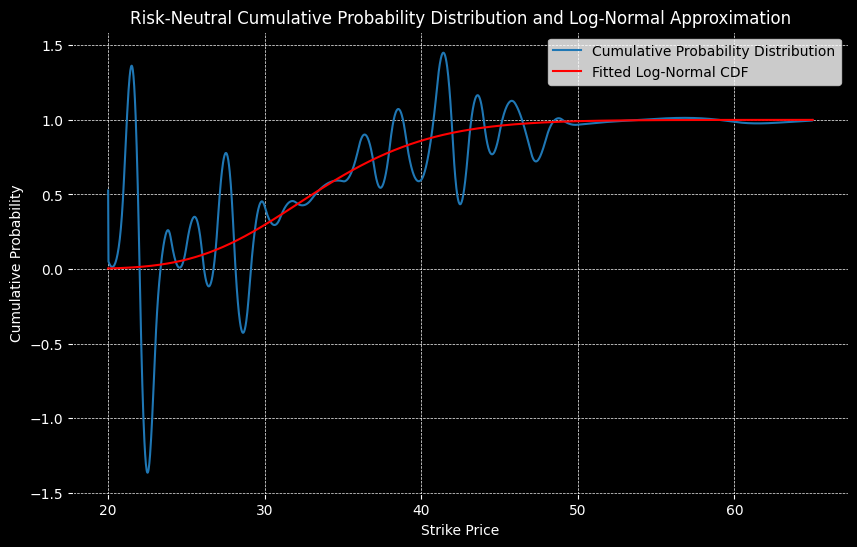

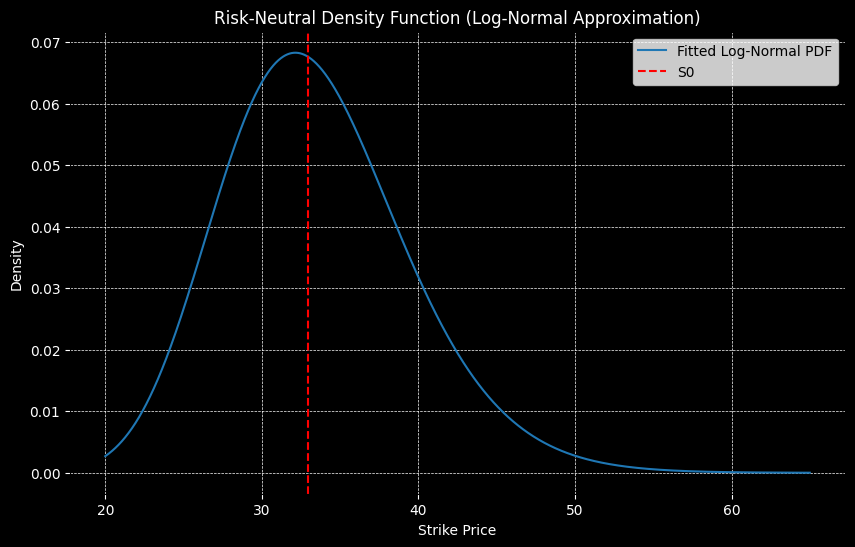

In [49]:

# Define the step size
delta = new_strikes[1] - new_strikes[0]

# Calculate the cumulative probability distribution
def cumulative_probability(call_prices, strikes, delta, r, T):
    exp_rtT = np.exp(r * T)
    cumulative_prob = 1 + exp_rtT / delta * (np.roll(call_prices, -1) - np.roll(call_prices, 1)) / 2
    cumulative_prob[0] = 1 + exp_rtT / delta * (call_prices[1] - call_prices[0]) / 2
    cumulative_prob[-1] = 1 + exp_rtT / delta * (call_prices[-1] - call_prices[-2]) / 2
    return cumulative_prob

# Calculate cumulative probability function
cumulative_prob = cumulative_probability(call_prices, new_strikes, delta, r, T)

# Fit log-normal CDF to the cumulative probability distribution
def lognormal_cdf(x, s, loc, scale):
    return lognorm.cdf(x, s, loc, scale)

# Improved initial guess for parameters: shape, loc, scale
initial_guess = [0.1, 0, S0]
popt, pcov = curve_fit(lognormal_cdf, new_strikes, cumulative_prob, p0=initial_guess, maxfev=4000)

# Print fitted parameters
print("Fitted parameters for log-normal distribution:")
print(f"Shape (s): {popt[0]}")
print(f"Location (loc): {popt[1]}")
print(f"Scale (scale): {popt[2]}")

# Define the log-normal PDF function
def lognormal_pdf(x, s, loc, scale):
    return lognorm.pdf(x, s, loc, scale)

# Plot the calculated cumulative probability distribution and the fitted log-normal CDF
plt.figure(figsize=(10, 6))
plt.plot(new_strikes, cumulative_prob, '-', label='Cumulative Probability Distribution')
plt.plot(new_strikes, lognormal_cdf(new_strikes, *popt), '-', label='Fitted Log-Normal CDF', color ='red')
plt.xlabel('Strike Price', color = 'white')
plt.ylabel('Cumulative Probability', color = 'white')
plt.title('Risk-Neutral Cumulative Probability Distribution and Log-Normal Approximation', color = 'white')
plt.legend()
# Set black background and white grid
plt.gca().set_facecolor('black')
plt.gcf().set_facecolor('black')
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.tick_params(colors='white')
plt.show()

# Calculate the PDF from the fitted log-normal parameters
pdf_values = lognormal_pdf(new_strikes, *popt)

# Plot the fitted log-normal PDF
plt.figure(figsize=(10, 6))
plt.plot(new_strikes, pdf_values, '-', label='Fitted Log-Normal PDF')
plt.axvline(x=S0, color='r', linestyle='--', label='S0')
plt.xlabel('Strike Price', color = 'white')
plt.ylabel('Density', color = 'white')
plt.title('Risk-Neutral Density Function (Log-Normal Approximation)', color = 'white')
plt.legend()
# Set black background and white grid
plt.gca().set_facecolor('black')
plt.gcf().set_facecolor('black')
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.tick_params(colors='white')
plt.show()

In [50]:
# Define the percentage ranges
percentage_ranges = [
                     (-30,-25),(-25, -20), (-20, -15), (-15, -10), (-10, -5), (-5, 0), 
                     (0, 5), (5, 10), (10, 15), (15, 20), (20, 25),(25,30) 
                    ]
# Calculate strike prices for the percentage ranges
strike_prices = [(S0 * (1 + start / 100), S0 * (1 + end / 100)) for start, end in percentage_ranges]
# Calculate the cumulative probabilities for the strike prices
cum_probs = [(lognorm.cdf(end, *popt) - lognorm.cdf(start, *popt)) for start, end in strike_prices]
# Create a DataFrame to display the results
columns = [f'{start}% < x < {end}%' for start, end in percentage_ranges]
results_df = pd.DataFrame([cum_probs], columns=columns)

# Format the probabilities as percentages
results_df = results_df.map(lambda x: f'{x:.7%}')

# Display the results using IPython.display
print("Probabilities of Price Changes:")
display(results_df)

Probabilities of Price Changes:


,-30% < x < -25%,-25% < x < -20%,-20% < x < -15%,-15% < x < -10%,-10% < x < -5%,-5% < x < 0%,0% < x < 5%,5% < x < 10%,10% < x < 15%,15% < x < 20%,20% < x < 25%,25% < x < 30%
0,3.0801240%,5.1072062%,7.3529899%,9.3691307%,10.7358137%,11.2132413%,10.7985110%,9.6824019%,8.1515187%,6.4905282%,4.9185699%,3.5669203%
